In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical
%matplotlib inline

In [2]:
def metric(ret):
    an_ret = empyrical.annual_return(ret, period='monthly')
    vol = empyrical.annual_volatility(ret, period='monthly')
    maxdraw = empyrical.max_drawdown(ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(an_ret / vol))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [3]:
wind = pd.read_excel('../data/wind.xlsx', index_col=0)

In [4]:
wind.head()

,Wind Index,Wind Index PE
881001.WI,,
1999-12-31,1000.0000,51.163799
2000-01-31,1160.7866,57.742001
2000-02-29,1302.4944,62.953602
2000-03-31,1374.5922,65.095001
2000-04-28,1392.4219,63.999599


In [5]:
df = pd.read_excel(u'../data/global strategy data.xlsx', sheet_name='data', skiprows=3, index_col=0)

In [6]:
df.head()

,SHCOMP Index,HSI Index,SPXT Index,LUATTRUU Index,CNDR1Y index,SHCOMP Index PE,HSI Index PE,SPX Index PE,FDTRMID Index
,,,,,,,,,
1998-01-30,147.7269,9899.9921,10871.21858,907.55,5.67,37.9330,8.2468,22.3680,5.5
1998-02-27,145.7360,12281.7879,11655.87159,904.85,5.67,37.4248,10.2275,23.9623,5.5
1998-03-31,150.0403,12394.0860,12253.33916,907.32,5.22,38.5320,10.2081,25.0065,5.5
1998-04-30,162.3269,11214.0025,12374.52510,911.36,5.22,41.6718,9.2122,25.3444,5.5
1998-05-29,170.6034,9704.1920,12163.88960,920.83,5.22,43.7736,7.9253,25.0354,5.5


In [7]:
df = df.merge(wind, left_index=True, right_index=True)

In [8]:
a_stock, hk_stock, us_stock = 'Wind Index', 'HSI Index', 'SPXT  Index'
asset_columns = [a_stock, hk_stock, us_stock, 'LUATTRUU Index']

In [9]:
assets_ret = df[asset_columns].pct_change()

In [10]:
fed_rate = df['FDTRMID Index']

# 计算估值偏离

In [11]:
pe = df[['Wind Index PE', 'HSI Index PE', 'SPX Index PE']]

In [12]:
pe_dev = (pe - pe.rolling(60).mean()) / pe.rolling(60).mean()

In [13]:
pe_dev = pe_dev.dropna()

# 回测

In [14]:
# 判断当前状态
def regime_weight(date):
    rate_change = fed_rate[fed_rate.index <= date].diff(3).iloc[-1]
    if rate_change == 0:
        return np.array([0.3, 0.3, 0.3, 0.1])
    elif rate_change > 0:
        return np.array([1./3, 1./3, 1./3, 0.])
    else:
        return np.array([0.8/3, 0.8/3, 0.8/3, 0.2])

In [15]:
def weight_change(w, dev):
    if dev < -0.3:
        return w + 0.35
    elif -0.3 <= dev and dev < -0.2:
        return w + 0.25
    elif -0.2 <= dev and dev < -0.1:
        return w + 0.15
    elif 0.1 <= dev and dev < 0.2:
        return max(0, w - 0.15)
    elif 0.2 <= dev and dev < 0.3:
        return max(0, w - 0.25)
    elif dev >= 0.3:
        return max(0, w - 0.35)
    else:
        return w

In [16]:
def calc_weight(date):
#     print(date)
    w = regime_weight(date)
    current_pe_dev = pe_dev[pe_dev.index <= date].loc[date]
    
#     print(w)
    
    init_w = w[:3].sum()
    w[0] = weight_change(w[0], current_pe_dev['Wind Index PE'])
    w[1] = weight_change(w[1], current_pe_dev['HSI Index PE'])
    w[2] = weight_change(w[2], current_pe_dev['SPX Index PE'])
    
#     print(w)

    sum_w = w[:3].sum()
    w[0] = w[0] * init_w / sum_w
    w[1] = w[1] * init_w / sum_w
    w[2] = w[2] * init_w / sum_w
    
#     print(w)

    return w

In [17]:
assets_ret = assets_ret[assets_ret.index >= '2012-01-01']

In [18]:
weight = pd.DataFrame(columns=assets_ret.columns, index=assets_ret.index)
n = assets_ret.shape[1]
wb = np.zeros(n)

for date in weight.index:
    wb = calc_weight(date)
    weight.loc[date] = wb

In [19]:
portfolio = (weight.shift(1) * assets_ret).sum(axis=1)

In [20]:
portfolio.tail()

2018-12-31   -0.056939
2019-01-31    0.042579
2019-02-28    0.098394
2019-03-29    0.045384
2019-04-30    0.016574
dtype: float64

In [21]:
portfolio = portfolio[portfolio != 0]

In [22]:
metric(portfolio)

Annual return: 12.98%
Sharpe ratio: 1.07
Annual volatility: 12.18%
Max drawdown: -15.67%


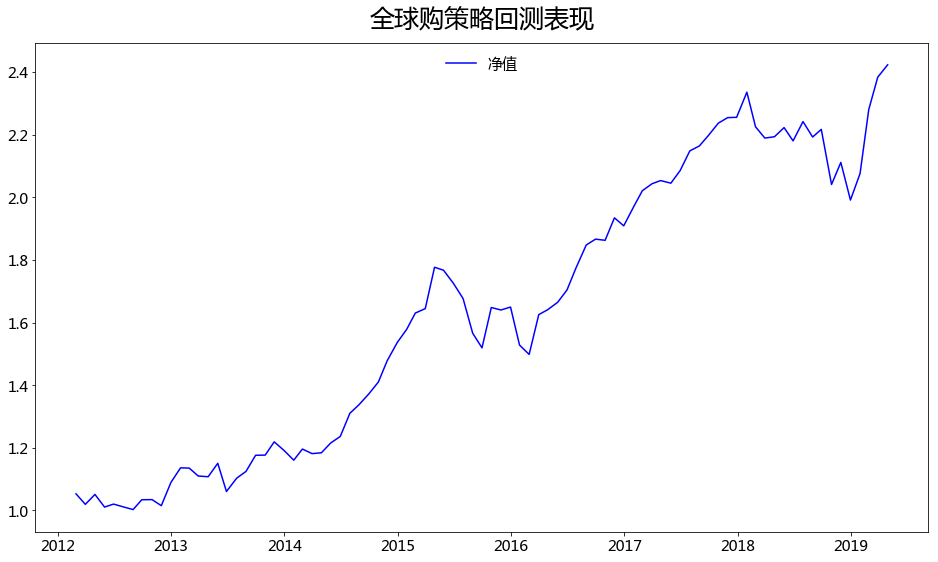

In [23]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + portfolio).cumprod(), color='blue', label=u'净值')

lns = lns1
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}'.format(x) for x in vals])

_ = ax.set_title(u'全球购策略回测表现', fontsize=25, y=1.02)

In [24]:
weight = weight.astype(np.float32)

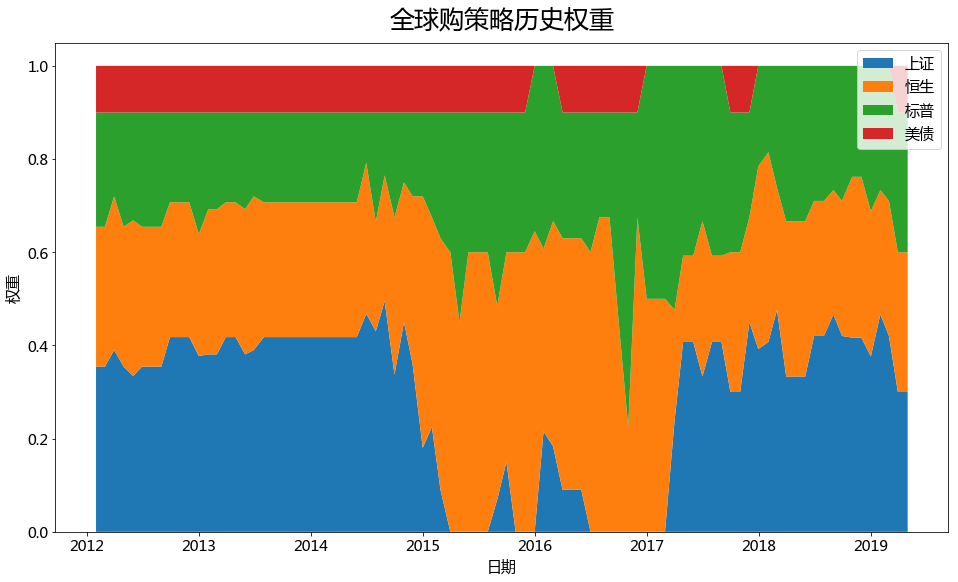

In [25]:
fig, ax = plt.subplots(figsize=(16, 9))
_ = ax.stackplot(weight.index, 
                 weight['Wind Index'],
                 weight['HSI Index'],
                 weight['SPXT  Index'],
                 weight['LUATTRUU Index'],
                 labels=[u'上证', u'恒生', u'标普', u'美债'])
ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
_ = ax.set_title(u'全球购策略历史权重', fontsize=25, y=1.02)

In [26]:
weight.tail()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
2018-12-31,0.376344,0.311828,0.311828,0.0
2019-01-31,0.466667,0.266667,0.266667,0.0
2019-02-28,0.420290,0.289855,0.289855,0.0
2019-03-29,0.300000,0.300000,0.300000,0.1
2019-04-30,0.300000,0.300000,0.300000,0.1


In [247]:
df.to_excel('C:/Users/zhangyang01/Desktop/global strategy.xlsx')

In [259]:
weight.to_excel('C:/Users/zhangyang01/Desktop/weight.xlsx')

In [260]:
portfolio.to_excel('C:/Users/zhangyang01/Desktop/portfolio.xlsx')